# 14. 어제 오른 내 주식, 과연 내일은? 💸

## 학습목표
- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
- 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

## 루브릭
|평가문항|	상세기준|
|:---|:---|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

## 1. 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 2. 데이터 전처리
시계열 데이터의 그래프를 그려보고 필요한 전처리를 수행합니다.
사용할 데이터는 안정적인 시계열 데이터가 아님을 알 수 있었고 이를 위해 필요한 전처리를 아래와 같이 수행해봅니다.

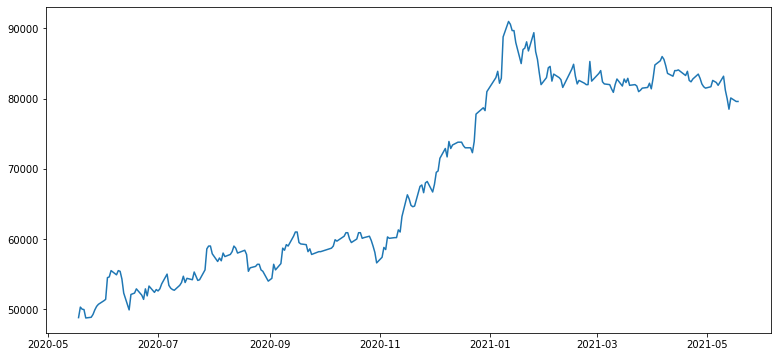

In [34]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts)

### 2.1 결측치 처리

In [8]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 2.2 로그 변환

시계열이 시간 추이에 따라 분산이 점점 커지고 있을때, 보다 Stationary한 시계열로 가공하기 위해 로그함수로 변환을 해주는 것이 도움이 됩니다.

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

## 3. 시계열 안정성 분석

### 3.1 정성적 그래프 분석

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해보겠습니다.

현재 타임스텝 부터 window에 주어진 타임스텝 이전 사이
1. 구간의 평균(rolling mean, 이동평균)과
2. 표준편차(rolling std, 이동표준편차)를

원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있습니다.

In [13]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

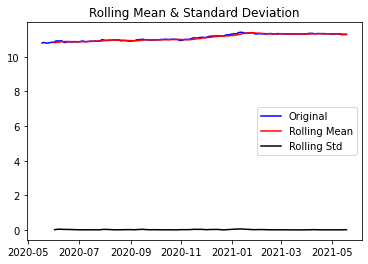

In [14]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

이동평균, 이동표준편차가 시간에 따라 함수적으로 변화하기 보다는 상수항으로 보입니다. 그래프 상에서는 안정적인 시계열 데이터로 볼 수 있을 것 같습니다.

### 3.2 정량적 Augmented Dicky-Fuller Test

In [15]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [16]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


ts_log 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 0.6에 가깝게 나타났습니다.
귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없습니다.

### 3.3 시계열 분해(Time Series Decomposition)

statsmodels 라이브러리 안에는 seasonal_decompose 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다.



> __추세(Trend)__<br>
시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다.

> __계절성(seasonality)__<br>
Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.
해마다 어떤 특정한 때나 1주일마다 특정 요일에 나타나는 것 같은 계절성 요인이 시계열에 영향을 줄 때 계절성(seasonality) 패턴이 나타납니다. 계절성은 빈도의 형태로 나타나는데, 그 빈도는 항상 일정하며 알려져 있습니다. 
출처: https://otexts.com/fppkr/tspatterns.html

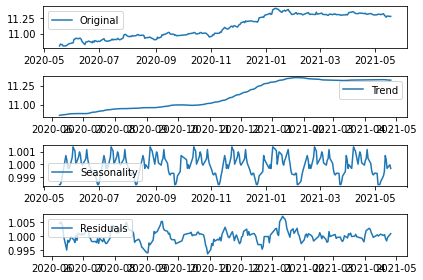

In [18]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다.

### 3.4 Residual 안정성 확인

In [19]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

분리 비율은 학습과 테스트에 9:1로 하겠습니다.

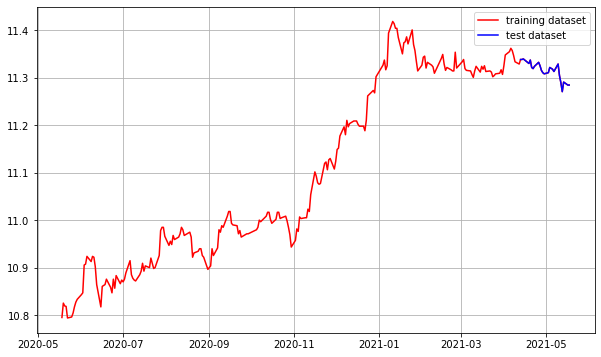

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. ARIMA 모델의 개념

ARIMA는 Autoregressive Integrated Moving Average의 약자로, Autoregressive는 자기회귀모형을 의미하고, Moving Average는 이동평균모형을 의미합니다.

###  AR(자기회귀, Autoregressive)
- 이전 관측값의 오차항이 이후 관측값에 영향을 주는 모델입니다.
- $AR(1): X_t=\Phi X_{t−1}+e_t$
  
###  MA(이동평균, Moving Average)
- MA는 관측값이 이전의 연속적인 오차항의 영향을 받는다는 모델입니다.
- $MA(1): X_t = e_t + B_1e_{t-1}$, beta는 이동평균계수, epsilon은 t시점의 오차항

- MA는 시계열의 Trend에 해당하는 부분을 모델링한다고 볼 수 있습니다.
- 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점이라고 볼 수 있습니다.

###  I(차분누적, Integration)
- I는 차분의 누적(integration) 합이라고 보는 모델입니다.
- I는 시계열의 Seasonality에 해당하는 부분을 모델링한다고 볼 수 있습니다.
- 예를 들어 $d=1$이라면 $Y_t$는 $Y_{t-1}$과 $\varDelta Y_{t-1}$의 합

현실의 시계열 자료는 불안정한 경우가 많은데, 모델 자체에 이런 불안정성을 제거하는 과정을 포함한 것이 ARIMA 모델입니다.

reference: https://byeongkijeong.github.io/ARIMA-with-Python/

##  6. 적정 ARIMA 모수 찾기

ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 합니다. 

ARIMA의 모수는 아래의 3가지가 있습니다

- p : 자기회귀 모형(AR)의 시차
- q : 이동평균 모형(MA)의 시차
- d : 차분누적(I) 횟수

ARIMA의 적절한 모수 p, d, q를 선택하는 대표적인 방법으로는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)가 있습니다.

- ACF
    - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
    - 주어진 시계열의 현재 값이 과거($y_{t-1},y_{t-2},...,y_{t-n}$)값과 어떻게 상관되는지 설명함
    - ACF plot에서 X축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

- PACF
    - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련서을 측정하는 함수
    - k 이외의 모든 시차를 갖는 관측치($y_{t-1},y_{t-2},...,y_{t-k+1}$)의 영향력을 배제한 가운데 특정 두 관측치, $y_t$와 $y_{t-k}$가 얼마나 관련이 있는지 나타내는 척도.

### 6.1 ACF, PACF (p,q 구하기)

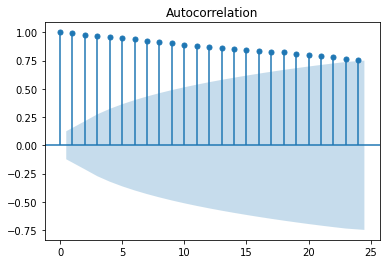

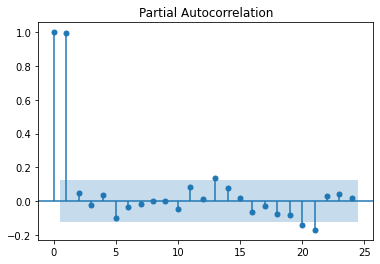

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있습니다.

__AR/MA 모형과 ACF/PACF 관계__<br>

||AR(p)|MA(q)|
|---|---|---|
|ACF|점차적으로 감소|시차q 이후에 0|
|PACF|시차 p이후에 0|점차적으로 감소|

이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.

시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소합니다.위 그래프는 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. 

### 6.2 차분 안정성 확인 (d 구하기)

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


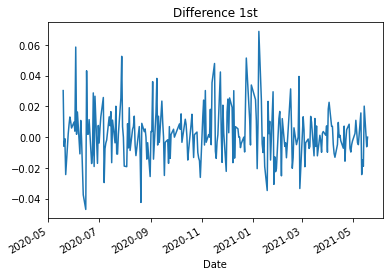

In [24]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


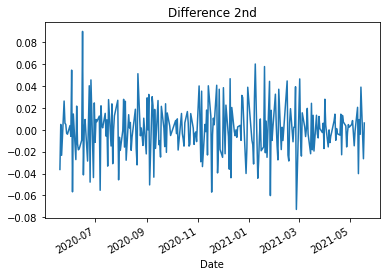

In [25]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분을 구했을 때는 안정화 상태이니 d=1로 먼저 시도하겠습니다.

## 7. ARIMA 모델 훈련과 테스트

### 6.1 ARIMA 모델 빌드와 훈련

In [54]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Build Model
model1 = ARIMA(train_data, order=(1, 1, 0))  # p, d, q
fitted_m1 = model1.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 535.977
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 09 Sep 2021   AIC                          -1065.954
Time:                        07:18:50   BIC                          -1055.732
Sample:                             2   HQIC                         -1061.827
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0001      0.001     -0.118      0.906      -0.002       0.002
ar.L1.D2.Close    -0.4759      0.059     -8.067      0.000      -0.591      -0.360
                                    

### 6.2 모델 테스트 및 플로팅

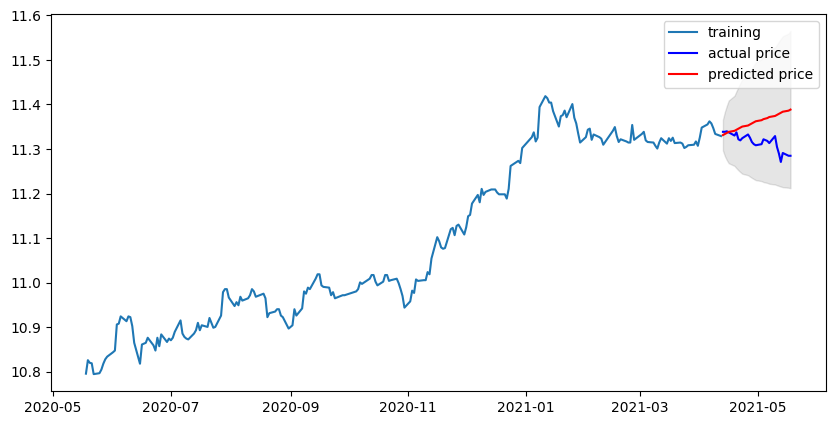

In [55]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m1.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 6.3 최종 예측 모델 정확도 측정(MAPE)

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 4.7% 정도의 오차율을 보입니다

> __MAPE(mean absolute percentage error)__<br>
    * MAPE는 퍼센트 값을 가지며 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있음<br>
    * 0~100% 사이의 값을 가져 이해하기 쉬우므로 성능 비교 해석이 가능

## 7. 관심 종목 예측해보기

디즈니, 넷플릭스, 구글의 주식 데이터를 이용해서 시계열 예측을 진행해보겠습니다.
- Time Period: Sep 09, 2020 - Sep 09, 2021 

### 7.1 Disney

In [57]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/DIS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-09    133.360001
2020-09-10    133.220001
2020-09-11    131.750000
2020-09-14    131.250000
2020-09-15    131.240005
Name: Close, dtype: float64

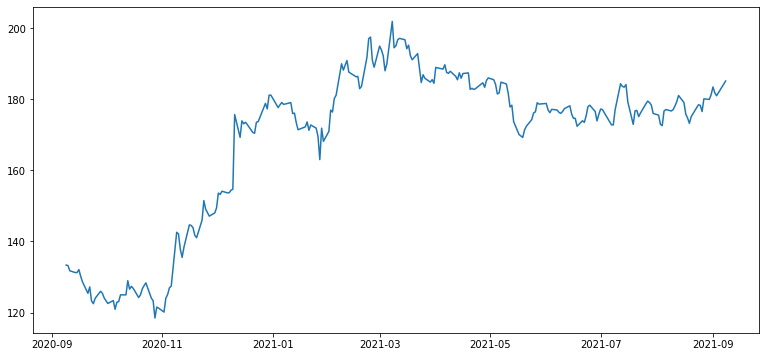

In [58]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts)

In [59]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [60]:
# 로그 변환 시도 
ts_log = np.log(ts)

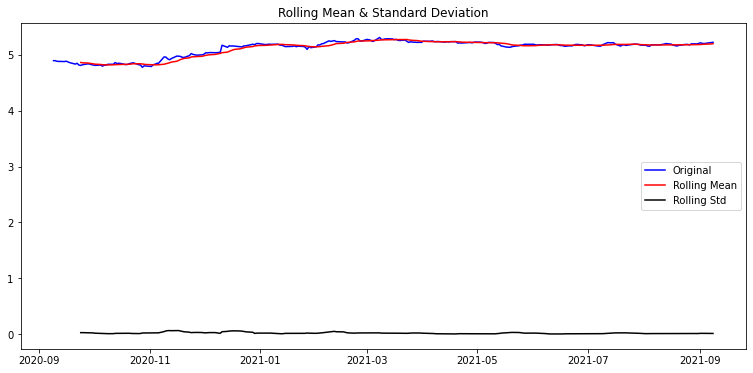

In [61]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [62]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.472080
p-value                          0.547275
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


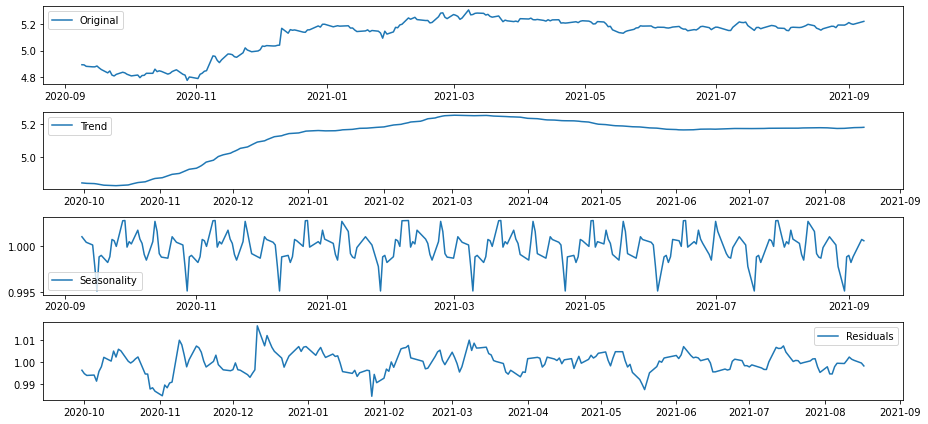

In [63]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [64]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.956480e+00
p-value                        2.087413e-07
#Lags Used                     5.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


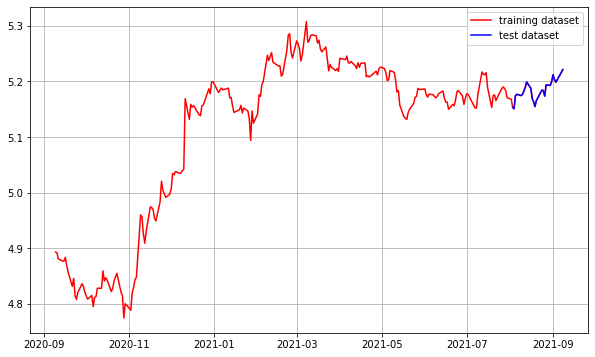

In [65]:
# split train, test 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

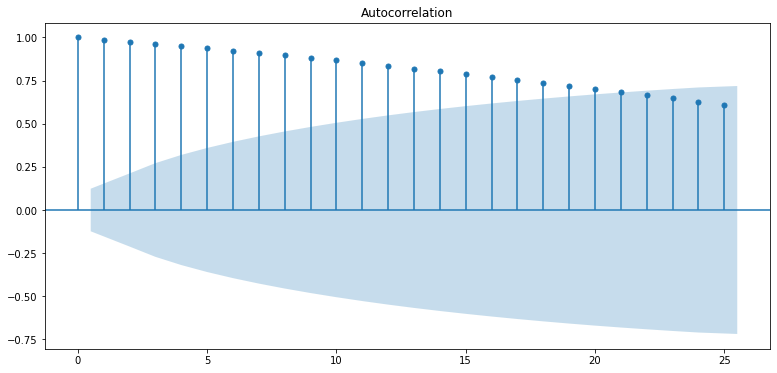

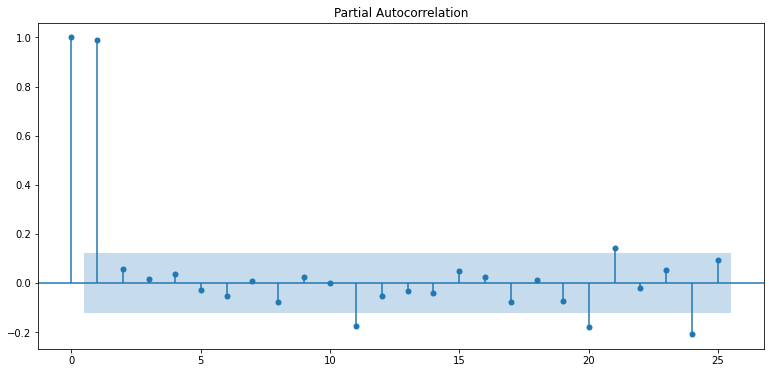

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소하기 때문에, 위 그래프는 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다.이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다

Results of Dickey-Fuller Test:
Test Statistic                -1.706035e+01
p-value                        7.954544e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


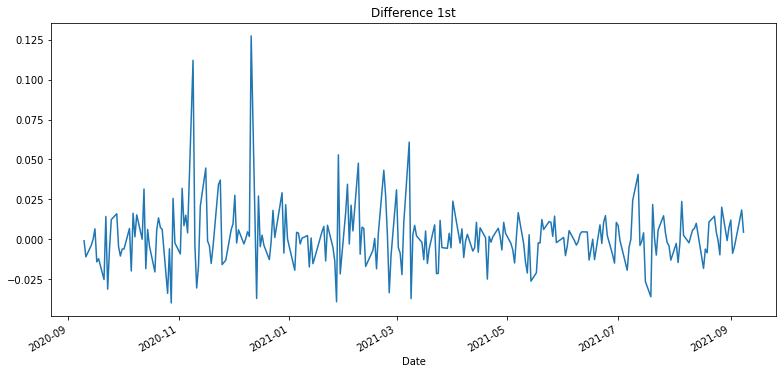

In [67]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [68]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 564.844
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 09 Sep 2021   AIC                          -1123.688
Time:                        07:44:32   BIC                          -1113.440
Sample:                             1   HQIC                         -1119.552
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.013      0.311      -0.001       0.004
ar.L1.D.Close    -0.0855      0.066     -1.289      0.197      -0.215       0.044
                                    Root

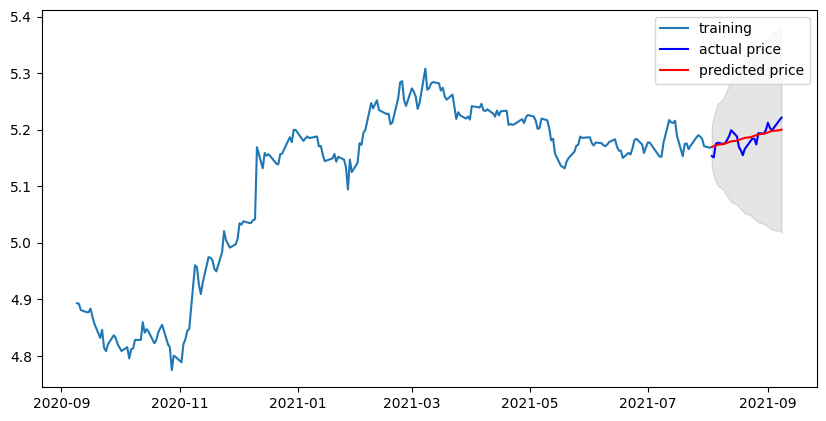

In [70]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [71]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5.5818283656606305
MAE:  1.871231277323389
RMSE:  2.362589334958708
MAPE: 1.05%


### 7.2 Netflix

In [145]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-09    500.190002
2020-09-10    480.670013
2020-09-11    482.029999
2020-09-14    476.260010
2020-09-15    495.989990
Name: Close, dtype: float64

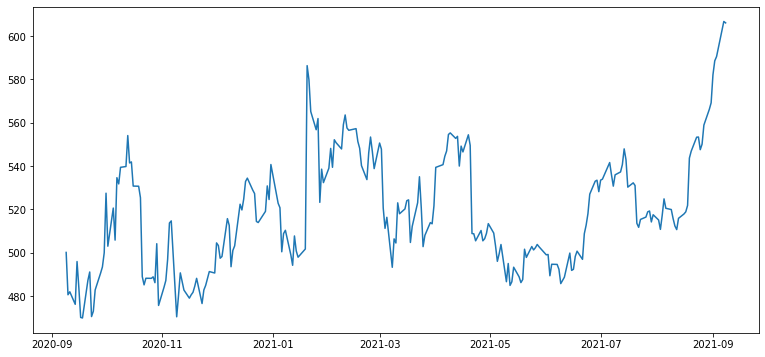

In [146]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts)

In [147]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [148]:
# 로그 변환 시도 
ts_log = np.log(ts)

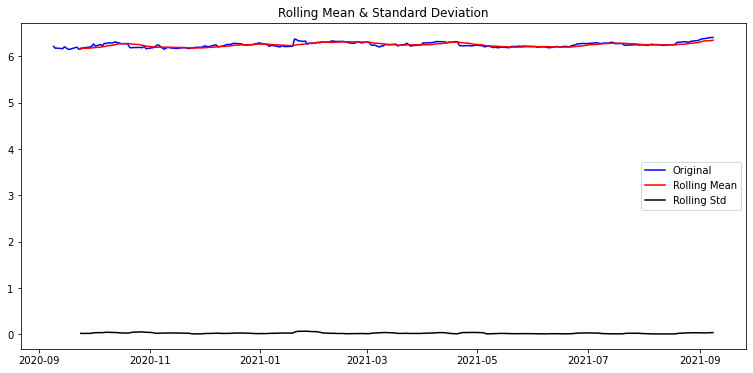

In [149]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [150]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.516241
p-value                          0.111573
#Lags Used                       1.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


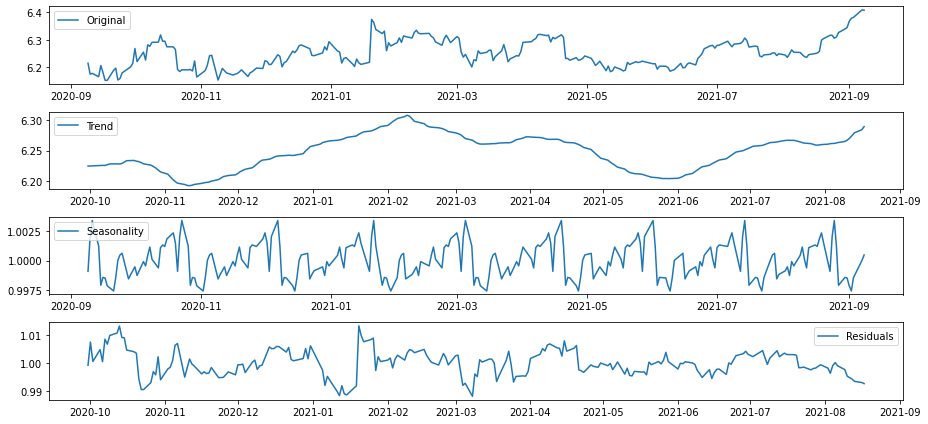

In [151]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [152]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.738415e+00
p-value                        6.358448e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


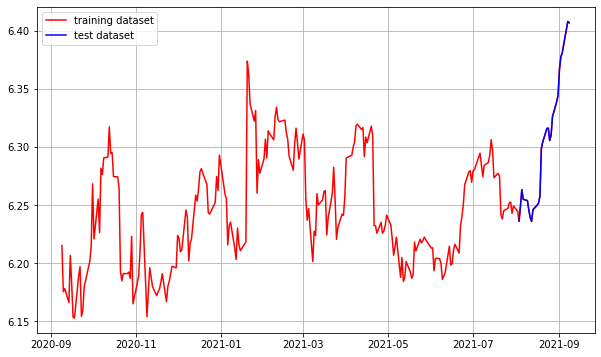

In [153]:
# split train, test 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

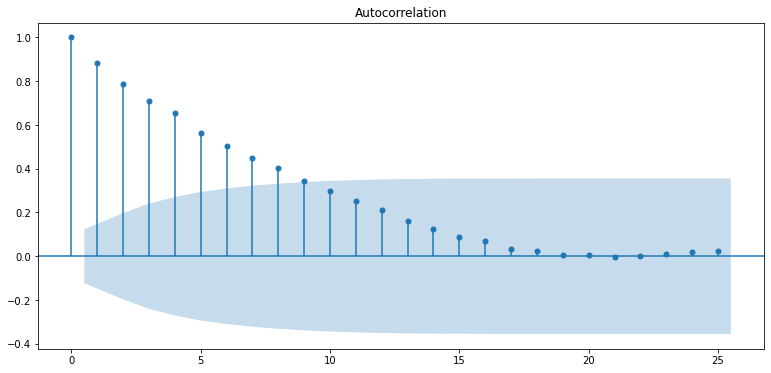

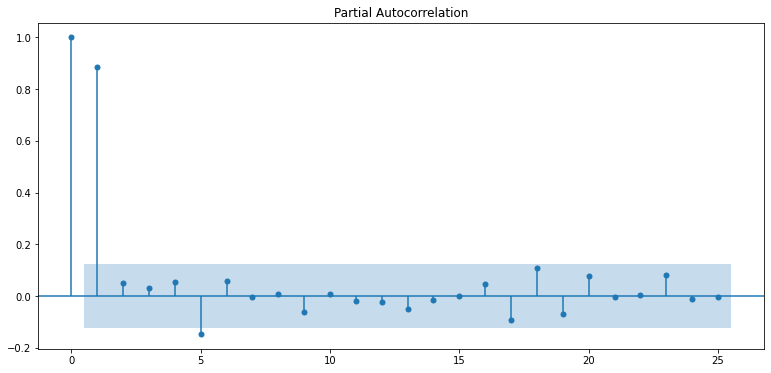

In [154]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF를 보면 16의 Time lag을 기준으로 자기상관이 양에서 0으로 변동합니다. 또한 PACF는 1의 Time lag에서 약 0.9를 보이고 이후에 급격히 감소합니다. 따라서 p=0, q=1이 적당하다고 추측할 수 있습니다.

Results of Dickey-Fuller Test:
Test Statistic                -7.539778e+00
p-value                        3.402299e-11
#Lags Used                     4.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


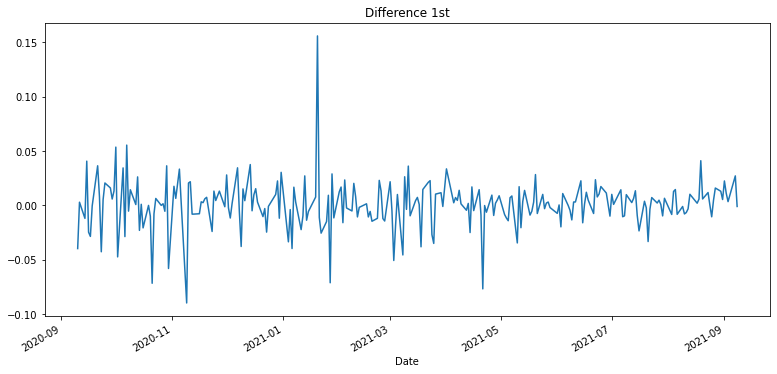

In [155]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [156]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 1))  # p, d, q
fitted_m = model.fit(trend = 'c', full_output = True, disp = True)
# fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 530.191
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 09 Sep 2021   AIC                          -1054.382
Time:                        08:33:31   BIC                          -1044.134
Sample:                             1   HQIC                         -1050.246
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.001      0.136      0.892      -0.002       0.003
ma.L1.D.Close    -0.1915      0.073     -2.634      0.008      -0.334      -0.049
                                    Root

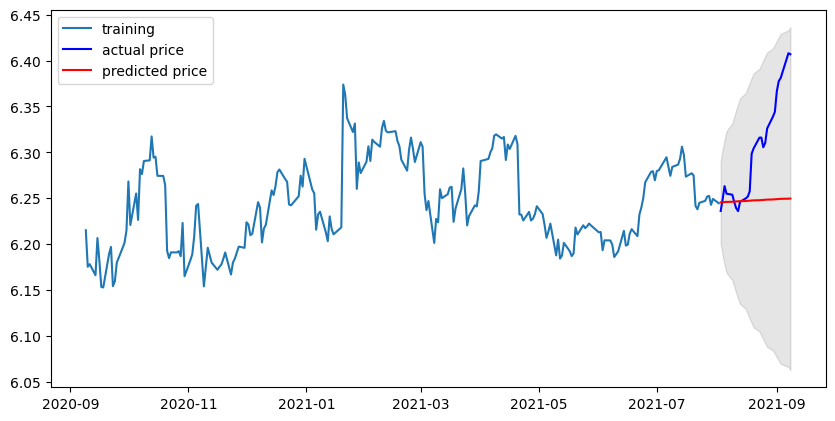

In [157]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [158]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1677.1244859186247
MAE:  29.42937112681903
RMSE:  40.95271036108141
MAPE: 5.14%


### 7.3 Google

In [159]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-09    1556.959961
2020-09-10    1532.020020
2020-09-11    1520.719971
2020-09-14    1519.280029
2020-09-15    1541.439941
Name: Close, dtype: float64

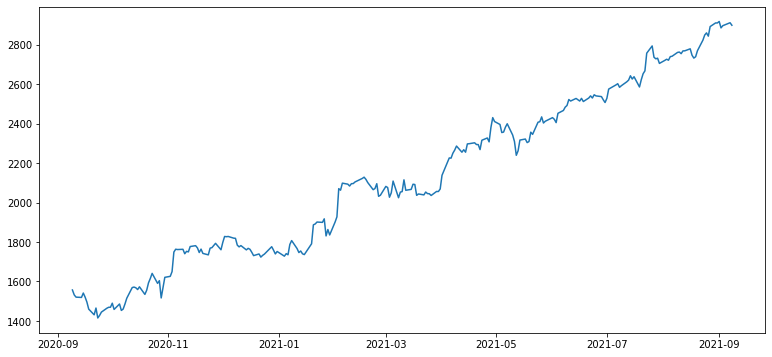

In [160]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts)

In [161]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [162]:
# 로그 변환 시도 
ts_log = np.log(ts)

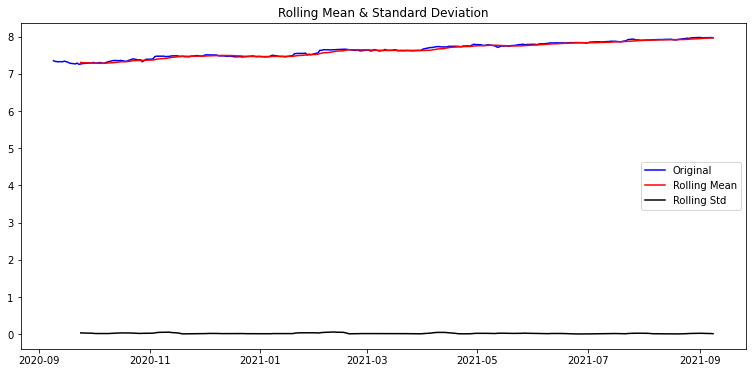

In [163]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [164]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.691995
p-value                          0.848812
#Lags Used                       7.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


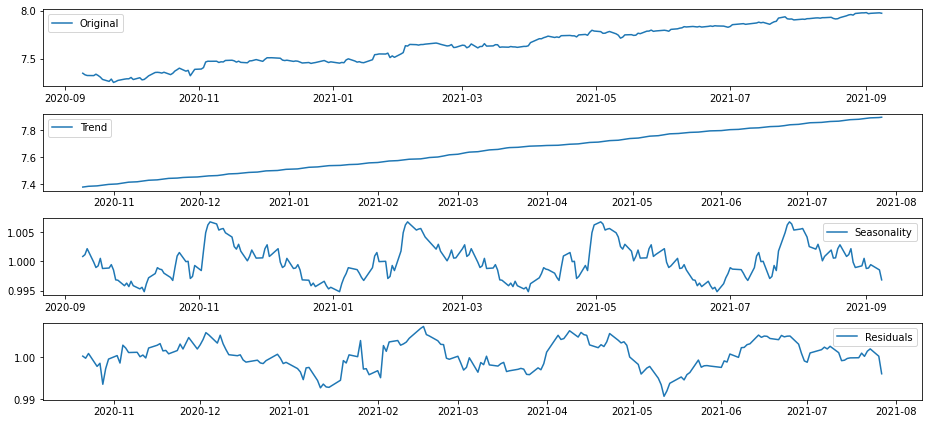

In [165]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 60) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [166]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.996372
p-value                          0.001430
#Lags Used                      12.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


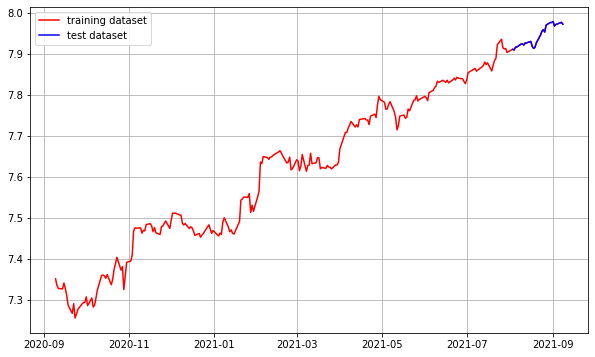

In [167]:
# split train, test 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

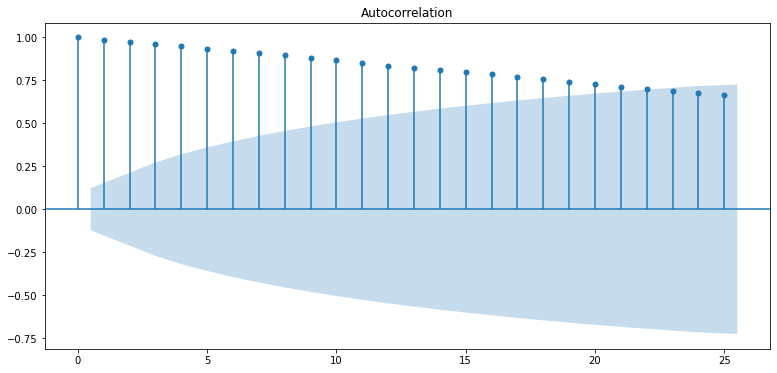

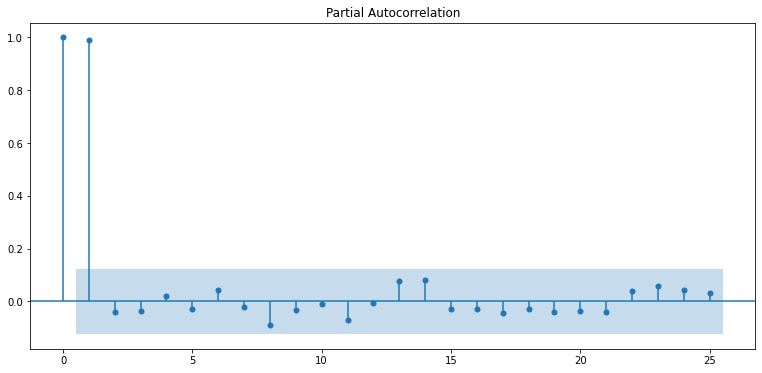

In [168]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.824653e+00
p-value                        1.961860e-09
#Lags Used                     6.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


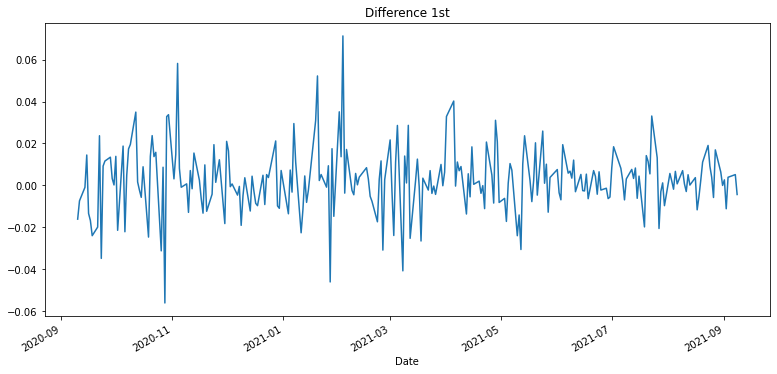

In [169]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [170]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # p, d, q
fitted_m = model.fit(trend = 'c', full_output = True, disp = True)
# fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 606.563
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 09 Sep 2021   AIC                          -1207.126
Time:                        08:34:28   BIC                          -1196.878
Sample:                             1   HQIC                         -1202.990
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0025      0.001      2.375      0.018       0.000       0.005
ar.L1.D.Close    -0.0419      0.067     -0.628      0.530      -0.173       0.089
                                    Root

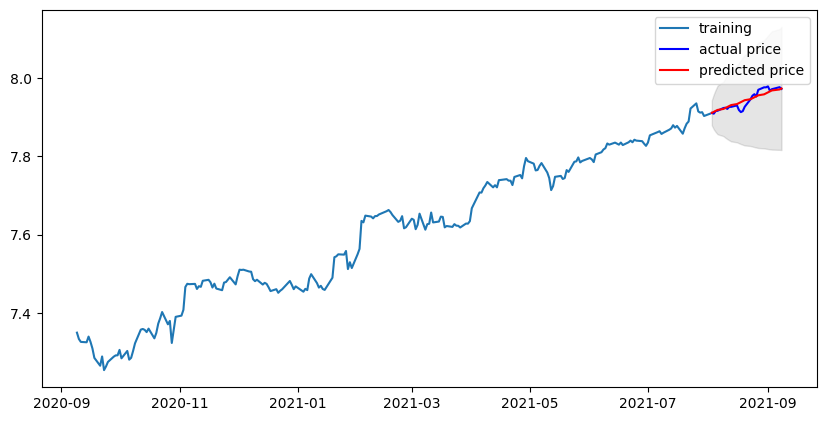

In [171]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [172]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  947.8482965232243
MAE:  21.679895941017723
RMSE:  30.78714498818012
MAPE: 0.77%


***

## 프로젝트 정리

- 디즈니, 넷플릭스, 구글의 주식 데이터 1년치를 가지고 시계열 예측을 수행해 보았습니다.
- augmented_dickey_fuller_test 결과 세 데이터 모두 p-value가 유의수준 0.05보다 훨씬 커 귀무가설을 기각할 수는 없게 되었으므로 안정적이지 않다고 판단하였습니다.
- 다른 두 종목과 달리 GOOGLE 은 30일 기준으로 시계열 분해를 했을때 Residual의 p-value가 0.071692로 유의수준보다 높아 그래프의 개형을 확인하고 60일 기준으로 다시 decompse를 수행하였습니다.최종적으로 얻은 Residual의 p-value는 0.001430였습니다.
- 적절한 p, q값을 찾기 위헤 ACF, PACF 그래프를 확인했을 때, 구글과 디즈니는 ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소하기 때문에, 위 그래프는 AR 모델에 유사한 형태를 보이고 있었습니다.
- 넷플릭스는 ACF를 보면 16의 Time lag을 기준으로 자기상관이 양에서 0으로 변동하였고, PACF는 1의 Time lag에서 약 0.9를 보이고 이후에 급격히 감소하는 MA모델에 유사한 형태를 보입니다.
- 따라서 넷플릭스의 ARIMA모델에는 p는 0, q는 1로 설정되었습니다.
- 자기상관이 0으로 변동되는 시차 q를 반영하여 ARIMA(0,1,16)으로 모델을 학습시켰을때 가장 좋은 결과인 MAPE: 4.51%가 나왔지만 일반적으로  p + q < 2인 값을 사용하기때문에 ARIMA(0,1,1)의 결과를 최종 결과물로 냈습니다. 다른 값으로 모델을 훈련시키기 위해서는 판단을 위한 좀 더 많은 공부가 필요할 것 같네요😂.
- 시계열 분해를 했을 때 세 데이터 모두 계절성이 잘 분해되었고, Trend의 추세가 단순할 수록 예측 결과가 좋은 것을 확인 할 수 있었습니다. (순서대로 Disney, Netflix, Google)
![trend](https://user-images.githubusercontent.com/32256247/132661218-5607468e-a21f-49b4-bd14-b33ae293630a.png)
- 세 종목의 MAPE 점수는 아래와 같습니다.

|종목|MSPE|
|---|---|
|Disney|1.05%|
|Netflix|5.14%|
|Google|0.77%|